# Concept

- DataSet은 신한 은행에서 취급하는 기본정보(SEX_GBN, AGE_GBN, ADD_GBN, INCOME_GBN, JOB_GBN, MARRY_Y, DOUBLE_IN, NUMCHILD)에 대한 모집단을 완성하는 것이다. 
- 기본 정보의 밀도 있는 조합으로 평균 값으로 대체를 해도 추정에는 무리가 없다. 


# ToBe

__1. target_set의 미응답처리__<br>

- train_set에는 미응답이 없다는 명세가 있다. 하지만 target_set에는 미응답이 있어야 한다. 미응답이 있을 경우 해당 컬럼에 대한 정보가 없어 예측 시 컬럼이 존재 할 경우 알고리즘에 영향을 미친다. target_set미응답에 해당하는 레코드는 분할하여 존재하는 레코드만 활용하여 예측을 해야 정성있는 예측이 가능하다.

__2. 결혼 유뮤에 따른 데이터 분류 분석__<br> 
- 결혼을 했다면 대부분의 사람들은 자산을 합치기 때문에 자산형성의 형태가 미혼인 사람들과 달라 동일 데이터로 분석을 한다면 서로 잡음으로 인식할 확률이 높다. <br> 실제로 분류하여 예측을 할 경우 정확도에 유의한 영향을 미친다.


__3. outlier 전처리 & feature selection __<br>

- 2-1 : 모집단을 평균으로 대체해도 무리가 없다는 가정하에 IQR을 이용한 6분위 분포를 생성 => entropy 정보를 확인한다.
- 2-2 : 밀도있는 그룹을 찾는 방법 -> 각 금융 정보에 대하여<br><br>

    - way1 : 수작업 -> 직업은 2번이면서 수입은 4번이고 아이는 2명 인 사람들 중에 해당 금융 정보(미리 지정하여 정의한)의 범위에 속한 그룹       - way2 : 확인 할 금융정보에 6분위 번호를 부여하여 기본속성의 분포가 가지는 특성을 파악하여 feature를 선택한다. 
    - way3 : 다변수 아노바를 활용.
    
__4. 모집단 DataSet을 완성 후 k-modes를 활용하여 군집 정보를 생성.__
- 3-1 : 기본 정보만으로 그룹을 나눈다는 것은 무의미 하다. 기본 속성은 모두 동일 하더라도 금융 정보에 따라 가지는 특성은 충분히 달라 진다. MISSION에서 추가로 입력 받는 ASS_FIN, M_TOT_SAVING, TOT_SOBI 정보를 같이 고려 해야 한다. 
- 3-2 : Alternative Way => ASS_FIN, M_TOT_SAVING, TOT_SOBI예측 후 way 1,2,3과 같은 기본 속성의 조합  


# ISSUE

1. MARRY_Y == 1<br>
    - 1-1 모집단 DataSet의 미혼이면서 DOULBL_IN, NUMCHILD가 NULL이 아닌 경우<br><br>
        - train_set 578 row

2. MARRY_Y ==2<br>
    - 2-1 모집단 DataSet의 기혼이면서 NUMCHILD가 NULL인 경우.
        - train_set 1212 row


In [1]:
import pandas as pd
import numpy as np
import operator

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv("20180811_DataSet.csv")

In [5]:
raw_d = pd.read_csv("20180811_DataSet.csv")

In [6]:
data_set = pd.read_csv("DataSet.csv")

In [7]:
raw =  pd.read_csv("DataSet.csv")

## 1. Explore data

In [8]:
data.head()

,idx,SEX_GBN,AGE_GBN,JOB_GBN,ADD_GBN,INCOME_GBN,MARRY_Y,DOUBLE_IN,NUMCHILD,TOT_ASSET,...,D_JEONSEA,RETIRE_NEED,FOR_RETIRE,TOT_YEA,TOT_JEOK,TOT_CHUNG,TOT_FUND,TOT_ELS_ETE,TOT_SOBI,M_CRD_SPD
0,5,1,2,2,4,2,1,NaN,NaN,2300,...,0,NaN,0,NaN,NaN,NaN,NaN,NaN,110,1437017
1,7,1,3,2,2,3,1,NaN,NaN,7500,...,0,NaN,30,2000.0,1000.0,800.0,NaN,NaN,104,3211358
2,9,2,3,2,2,6,2,2.0,1.0,41900,...,0,NaN,0,800.0,500.0,1200.0,NaN,NaN,300,2932871
3,10,1,5,2,4,6,2,1.0,3.0,123200,...,0,NaN,0,NaN,NaN,350.0,NaN,NaN,400,3106659
4,11,1,4,2,2,6,2,1.0,2.0,33500,...,0,200.0,0,NaN,NaN,NaN,NaN,NaN,350,3615840


In [9]:
data.drop('idx', inplace = True, axis = 1)

### 1-1 basic info check 

In [10]:
data.iloc[:,:9].apply(lambda x : x.isnull().sum())

SEX_GBN          0
AGE_GBN          0
JOB_GBN          0
ADD_GBN          0
INCOME_GBN       0
MARRY_Y          0
DOUBLE_IN     6524
NUMCHILD      7158
TOT_ASSET        0
dtype: int64

In [11]:
print(data[data['MARRY_Y'] == 1][['DOUBLE_IN', 'NUMCHILD']].apply(lambda x : x.isnull().sum()))
print('미혼 인원 수 =>' , len(data[data['MARRY_Y'] == 1]))

DOUBLE_IN    6524
NUMCHILD     5946
dtype: int64
미혼 인원 수 => 6524


In [12]:
data[(data['MARRY_Y'] == 1) & (data['NUMCHILD'].notnull())].shape

(578, 34)

In [13]:
data[(data['MARRY_Y'] == 1) & (data['NUMCHILD'].notnull())].iloc[:,:8].apply(lambda x: x.value_counts()).fillna("")

,SEX_GBN,AGE_GBN,JOB_GBN,ADD_GBN,INCOME_GBN,MARRY_Y,DOUBLE_IN,NUMCHILD
1,289,,,18,22,578,,211
2,289,8,193,97,133,,,320
3,,41,29,142,151,,,47
4,,164,16,141,123,,,
5,,307,,180,57,,,
6,,58,11,,61,,,
7,,,58,,31,,,
8,,,69,,,,,
9,,,103,,,,,
10,,,70,,,,,


미혼 이면서 자녀가 있는 경우는 578명이 존재한다. 
40대 이상이 상당부분 차지하고 있다. 

In [14]:
data[(data['MARRY_Y'] == 2) & (data['NUMCHILD'].isnull())].shape

(1212, 34)

In [15]:
data[(data['MARRY_Y'] == 2) & (data['NUMCHILD'].isnull())].iloc[:,:8].apply(lambda x: x.value_counts()).fillna("")

,SEX_GBN,AGE_GBN,JOB_GBN,ADD_GBN,INCOME_GBN,MARRY_Y,DOUBLE_IN,NUMCHILD
1,642,,,48,1,,177,
2,570,224,706,207,36,1212,1035,
3,,597,63,279,108,,,
4,,256,43,327,200,,,
5,,110,,351,335,,,
6,,25,20,,403,,,
7,,,49,,129,,,
8,,,82,,,,,
9,,,134,,,,,
10,,,87,,,,,


설문에  응답할 의무가 있어 기혼인 경우에는 NUMCHILD에 NULL값이 없어야 하나 1212명이 존재 한다. 
<br>20~30대가 많고 40대 이상도 약 400명이 있다.
<br>자녀 0명으로 대체 한다.
___

### 1-2 financial info check 

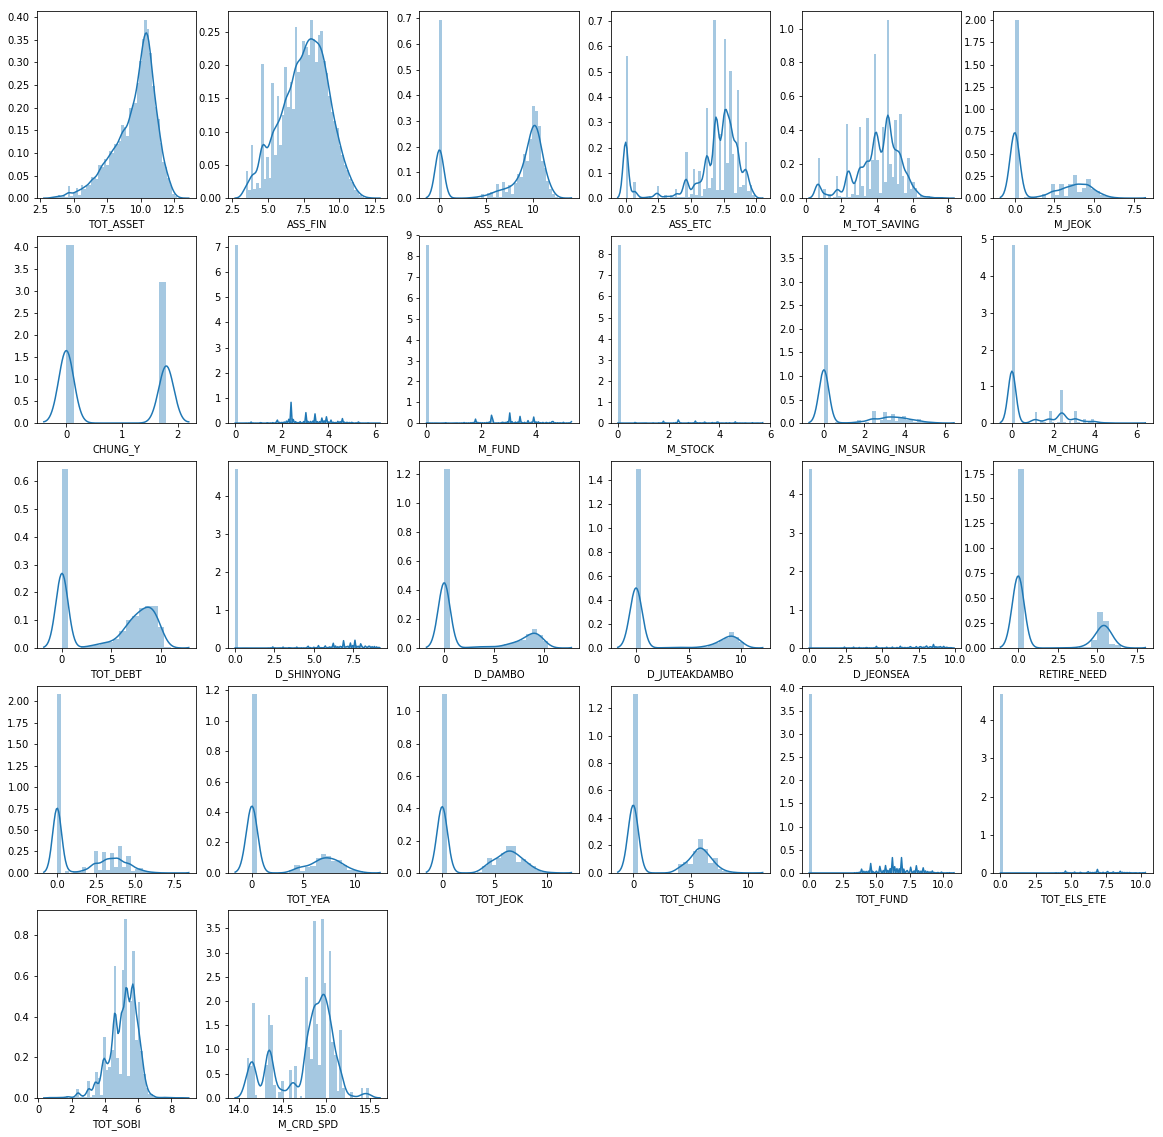

In [16]:
plt.figure(figsize=(20,20))
for i in range(len(data.iloc[:,8:].columns) ):
        plt.subplot(5,6,i + 1)
        sns.distplot(np.log1p(data[data.iloc[:,8:].columns[i]].fillna(0)))    
plt.show()

In [17]:
all_na = pd.DataFrame({'NA_Ratio' : data.iloc[:,8:].apply(lambda x : sum(x.fillna(0) == 0) / len(data.iloc[:,1]) * 100)}).sort_values(by = 'NA_Ratio', ascending = True)

In [18]:
all_na

,NA_Ratio
TOT_ASSET,0.000000
TOT_SOBI,0.000000
M_TOT_SAVING,0.000000
M_CRD_SPD,0.000000
ASS_FIN,0.000000
ASS_ETC,11.120871
ASS_REAL,22.148044
TOT_DEBT,41.584680
TOT_JEOK,51.985242
FOR_RETIRE,54.491684


___

### 1-3 TOT_SOBI, M_TOT_SAVING, ASS_FIN 
#### 기본 정보 분포 확인

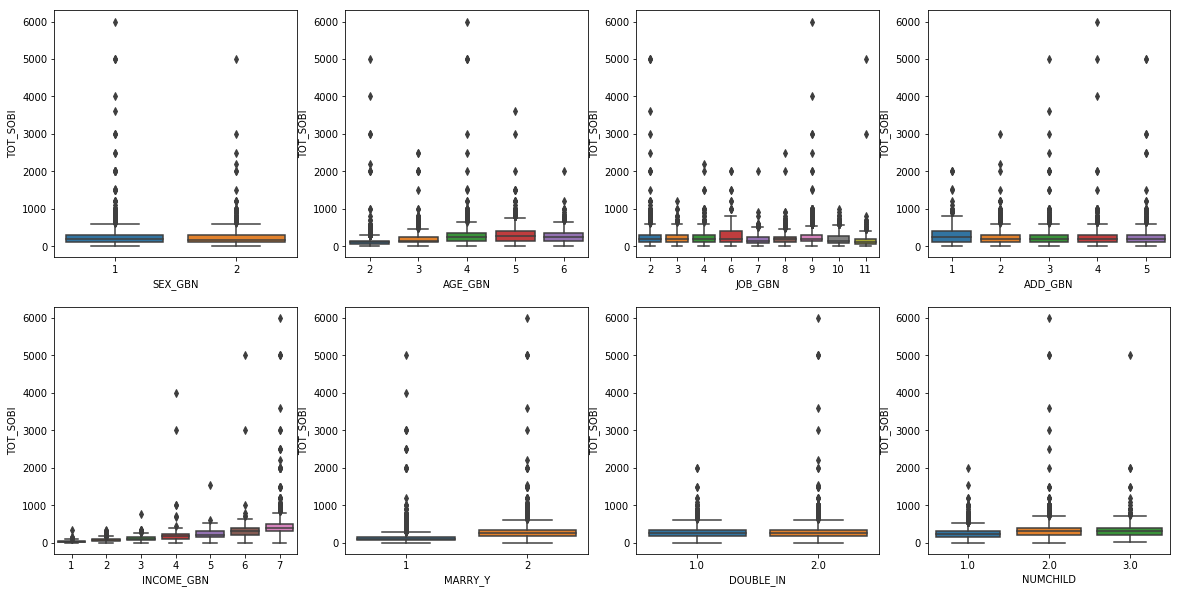

In [19]:
plt.figure(figsize=(20,10))
for i in range(len(data.iloc[:,:8].columns) ):
        plt.subplot(2,4,i + 1)
        sns.boxplot(x=data.iloc[:,:8].columns[i], y='TOT_SOBI', data=data)
plt.show()

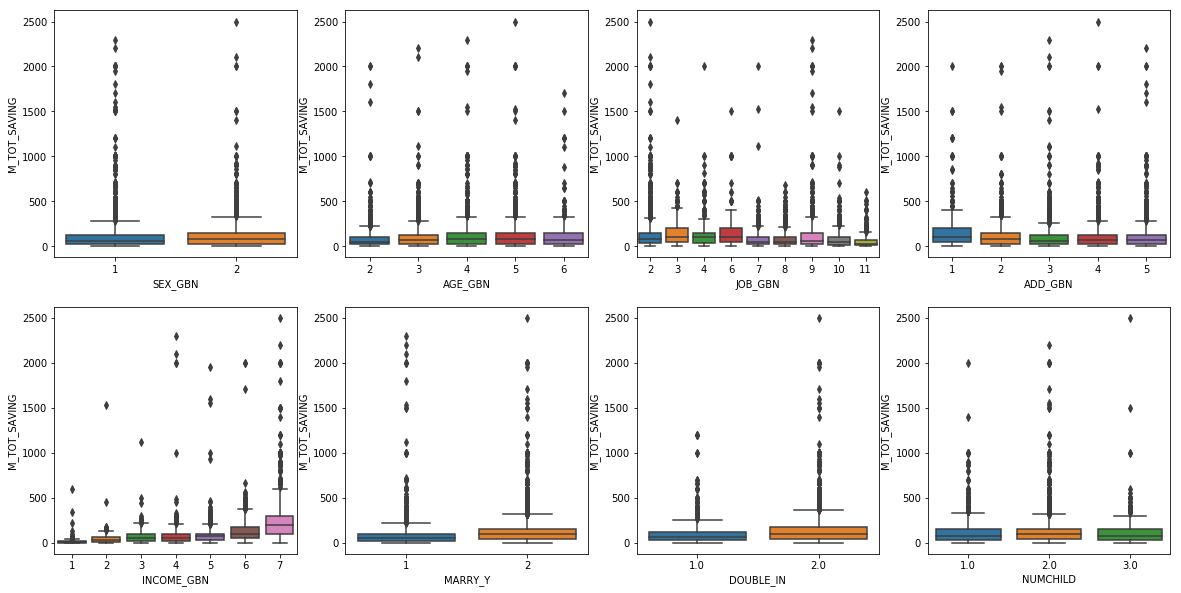

In [20]:
plt.figure(figsize=(20,10))
for i in range(len(data.iloc[:,:8].columns) ):
        plt.subplot(2,4,i + 1)
        sns.boxplot(x=data.iloc[:,:8].columns[i], y='M_TOT_SAVING', data=data)
plt.show()

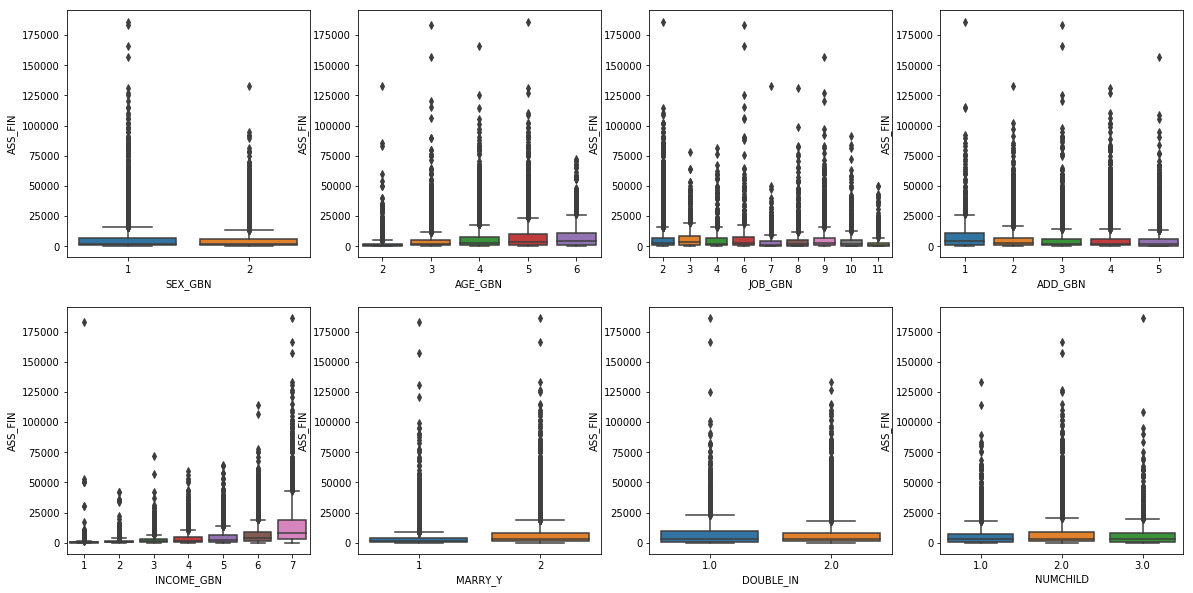

In [21]:
plt.figure(figsize=(20,10))
for i in range(len(data.iloc[:,:8].columns) ):
        plt.subplot(2,4,i + 1)
        sns.boxplot(x=data.iloc[:,:8].columns[i], y='ASS_FIN', data=data)
plt.show()

___

# 2. Feature Engineering & Selection

In [22]:
import math
import copy

In [23]:
def sep6_percentile(data, col, name = 'GROUP_1'):
    
    qt = list(data[col].describe()[3:8])
    IQR1_5 = qt[3] + ((qt[3] - qt[1]) * 1.5) ; qt.insert(-1, IQR1_5)
    IQR3 = qt[3] + ((qt[3] - qt[1]) * 3); qt.insert(-1, IQR3)

    for i in range(len(qt) - 1):
        idx = list(data[data[col].between(qt[i], qt[i+1], inclusive=True)].index)
        data.loc[np.array(idx), name] = i+1 
    data[name] = data[name].astype(int)
    return data

In [24]:
def get_entropy(data, col):
    set_col = list(set(data[col]))
    set_col.sort()
    print(set_col)
    for i in set_col:
        a = data[data[col] == i].iloc[:,:8].apply(lambda x : x.value_counts()).fillna(0)
            
        group_cnt = sum(a.iloc[:,1].values[np.where(a.iloc[:,1].values !=0)])
        
        if col in a.columns:
            search_col = a.columns.drop(col)
        else : 
            search_col = a.columns    
        
        print('\n')
        print(col + '_' + str(i))
        for j in search_col:
            wh = np.where(a[j].values in a[j].values !=0 )
            
            for_ent = 0
        
            for k in range(len(wh)):
                for_ent += -(a[j].values[wh[0][k]] / group_cnt * math.log(a[j].values[wh[0][k]] / group_cnt,2))
            print(j, '=>', '[',round(for_ent,4),']', end=' ')

In [25]:
#미응답은 4로 통일
data.loc[(data['MARRY_Y'] == 2) & (data['NUMCHILD'].isnull()), 'NUMCHILD'] = 0
#data.drop('idx', inplace = True , axis = 1)
data.iloc[:,:8] = data.iloc[:,:8].fillna(4)
data_set.iloc[:,1:9] = data_set.iloc[:,1:9].fillna(4) 

### 2-1 자본 컬럼 추가
- 자산(TOT_ASSET) = 자본(TOT_CAPITAL) + 부채(TOT_DEBT)

In [26]:
data['TOT_CAPITAL'] = data['TOT_ASSET'] - data['TOT_DEBT']
data[['INCOME_GBN', 'TOT_CAPITAL']].groupby('INCOME_GBN', as_index=False).mean().sort_values('TOT_CAPITAL', ascending=False)

,INCOME_GBN,TOT_CAPITAL
6,7,67010.830595
5,6,37340.072236
4,5,26970.112189
3,4,18639.029467
2,3,10569.464779
1,2,5347.356797
0,1,4880.621560


In [27]:
data['TOT_CAPITAL'].describe()

count     17076.000000
mean      28425.191848
std       37156.941758
min      -48948.000000
25%        4420.000000
50%       16700.000000
75%       37900.000000
max      415300.000000
Name: TOT_CAPITAL, dtype: float64

### 2-2 예측변수 6분위 분포에 따른 기본 속성 엔트로피 확인

###### TOT_CAPITAL

In [28]:
gr_data = sep6_percentile(data, 'TOT_CAPITAL')

In [29]:
get_entropy(gr_data, 'GROUP_1')

[1, 2, 3, 4, 5, 6]


GROUP_1_1
SEX_GBN => [ 0.4861 ] AGE_GBN => [ 0.5137 ] JOB_GBN => [ 0.5115 ] ADD_GBN => [ 0.1501 ] INCOME_GBN => [ 0.2851 ] MARRY_Y => [ 0.3087 ] DOUBLE_IN => [ 0.2104 ] NUMCHILD => [ 0.2013 ] 

GROUP_1_2
SEX_GBN => [ 0.4612 ] AGE_GBN => [ 0.476 ] JOB_GBN => [ 0.4953 ] ADD_GBN => [ 0.1442 ] INCOME_GBN => [ 0.0995 ] MARRY_Y => [ 0.5125 ] DOUBLE_IN => [ 0.3382 ] NUMCHILD => [ 0.333 ] 

GROUP_1_3
SEX_GBN => [ 0.4248 ] AGE_GBN => [ 0.2552 ] JOB_GBN => [ 0.4938 ] ADD_GBN => [ 0.1549 ] INCOME_GBN => [ 0.0434 ] MARRY_Y => [ 0.4468 ] DOUBLE_IN => [ 0.4285 ] NUMCHILD => [ 0.3174 ] 

GROUP_1_4
SEX_GBN => [ 0.4208 ] AGE_GBN => [ 0.197 ] JOB_GBN => [ 0.4872 ] ADD_GBN => [ 0.2254 ] INCOME_GBN => [ 0.0217 ] MARRY_Y => [ 0.3809 ] DOUBLE_IN => [ 0.4622 ] NUMCHILD => [ 0.2237 ] 

GROUP_1_5
SEX_GBN => [ 0.3937 ] AGE_GBN => [ 0.1646 ] JOB_GBN => [ 0.4728 ] ADD_GBN => [ 0.3956 ] INCOME_GBN => [ 0.0246 ] MARRY_Y => [ 0.3572 ] DOUBLE_IN => [ 0.4684 ] NUMCHILD => [ 0.1646 ] 

GROUP_1_6
SE

GOOD => INCOME_GBN, AGE_GBN, ADD_GBN<br>BAD => SEX_GBN, JOB_GBN
___

###### ASS_FIN

In [30]:
gr_Asset = sep6_percentile(data, 'ASS_FIN')

In [31]:
get_entropy(gr_Asset, 'GROUP_1')

[1, 2, 3, 4, 5, 6]


GROUP_1_1
SEX_GBN => [ 0.4281 ] AGE_GBN => [ 0.5282 ] JOB_GBN => [ 0.5232 ] ADD_GBN => [ 0.1558 ] INCOME_GBN => [ 0.2807 ] MARRY_Y => [ 0.4867 ] DOUBLE_IN => [ 0.3303 ] NUMCHILD => [ 0.2586 ] 

GROUP_1_2
SEX_GBN => [ 0.4657 ] AGE_GBN => [ 0.508 ] JOB_GBN => [ 0.498 ] ADD_GBN => [ 0.1648 ] INCOME_GBN => [ 0.113 ] MARRY_Y => [ 0.5199 ] DOUBLE_IN => [ 0.3482 ] NUMCHILD => [ 0.2943 ] 

GROUP_1_3
SEX_GBN => [ 0.4682 ] AGE_GBN => [ 0.4079 ] JOB_GBN => [ 0.4771 ] ADD_GBN => [ 0.1923 ] INCOME_GBN => [ 0.036 ] MARRY_Y => [ 0.5291 ] DOUBLE_IN => [ 0.3764 ] NUMCHILD => [ 0.2924 ] 

GROUP_1_4
SEX_GBN => [ 0.4461 ] AGE_GBN => [ 0.2222 ] JOB_GBN => [ 0.4769 ] ADD_GBN => [ 0.2388 ] INCOME_GBN => [ 0.0379 ] MARRY_Y => [ 0.4963 ] DOUBLE_IN => [ 0.426 ] NUMCHILD => [ 0.2546 ] 

GROUP_1_5
SEX_GBN => [ 0.4228 ] AGE_GBN => [ 0.1735 ] JOB_GBN => [ 0.4848 ] ADD_GBN => [ 0.2435 ] INCOME_GBN => [ 0.0121 ] MARRY_Y => [ 0.4479 ] DOUBLE_IN => [ 0.4768 ] NUMCHILD => [ 0.2125 ] 

GROUP_1_6
SEX_

GOOD => INCOME_GBN, AGE_GBN, ADD_GBN, NUMCHILD<br>BAD => MARRY_Y, JOB_GBN, SEX_GBN
___

###### M_TOT_SAVING

In [32]:
gr_MSaving = sep6_percentile(data, 'M_TOT_SAVING')

In [33]:
get_entropy(gr_MSaving, 'GROUP_1')

[1, 2, 3, 4, 5, 6]


GROUP_1_1
SEX_GBN => [ 0.4288 ] AGE_GBN => [ 0.5161 ] JOB_GBN => [ 0.529 ] ADD_GBN => [ 0.1544 ] INCOME_GBN => [ 0.3263 ] MARRY_Y => [ 0.4918 ] DOUBLE_IN => [ 0.3795 ] NUMCHILD => [ 0.2277 ] 

GROUP_1_2
SEX_GBN => [ 0.4391 ] AGE_GBN => [ 0.4615 ] JOB_GBN => [ 0.499 ] ADD_GBN => [ 0.1658 ] INCOME_GBN => [ 0.0841 ] MARRY_Y => [ 0.5278 ] DOUBLE_IN => [ 0.3967 ] NUMCHILD => [ 0.2537 ] 

GROUP_1_3
SEX_GBN => [ 0.4638 ] AGE_GBN => [ 0.4694 ] JOB_GBN => [ 0.4678 ] ADD_GBN => [ 0.2039 ] INCOME_GBN => [ 0.007 ] MARRY_Y => [ 0.5304 ] DOUBLE_IN => [ 0.3744 ] NUMCHILD => [ 0.2715 ] 

GROUP_1_4
SEX_GBN => [ 0.4559 ] AGE_GBN => [ 0.3756 ] JOB_GBN => [ 0.4706 ] ADD_GBN => [ 0.2236 ] INCOME_GBN => [ 0.0038 ] MARRY_Y => [ 0.5124 ] DOUBLE_IN => [ 0.372 ] NUMCHILD => [ 0.3035 ] 

GROUP_1_5
SEX_GBN => [ 0.4749 ] AGE_GBN => [ 0.2153 ] JOB_GBN => [ 0.4925 ] ADD_GBN => [ 0.2954 ] INCOME_GBN => [ 0.0109 ] MARRY_Y => [ 0.3642 ] DOUBLE_IN => [ 0.3865 ] NUMCHILD => [ 0.3782 ] 

GROUP_1_6
SEX

GOOD => INCOME_GBN, ADD_GBN, NUMCHILD, DOUBLE_IN<br>BAD => MARRY_Y, JOB_GBN, SEX_GBN
___

###### TOT_SOBI

In [34]:
gr_sobi = sep6_percentile(data, 'TOT_SOBI')

In [35]:
get_entropy(gr_sobi, 'GROUP_1')

[1, 2, 3, 4, 5, 6]


GROUP_1_1
SEX_GBN => [ 0.4952 ] AGE_GBN => [ 0.5071 ] JOB_GBN => [ 0.5153 ] ADD_GBN => [ 0.1564 ] INCOME_GBN => [ 0.3739 ] MARRY_Y => [ 0.2607 ] DOUBLE_IN => [ 0.1857 ] NUMCHILD => [ 0.1894 ] 

GROUP_1_2
SEX_GBN => [ 0.4605 ] AGE_GBN => [ 0.5059 ] JOB_GBN => [ 0.4933 ] ADD_GBN => [ 0.175 ] INCOME_GBN => [ 0.0124 ] MARRY_Y => [ 0.4698 ] DOUBLE_IN => [ 0.3322 ] NUMCHILD => [ 0.3142 ] 

GROUP_1_3
SEX_GBN => [ 0.4342 ] AGE_GBN => [ 0.2867 ] JOB_GBN => [ 0.5034 ] ADD_GBN => [ 0.1765 ] INCOME_GBN => [ 0.0171 ] MARRY_Y => [ 0.4638 ] DOUBLE_IN => [ 0.436 ] NUMCHILD => [ 0.3361 ] 

GROUP_1_4
SEX_GBN => [ 0.4138 ] AGE_GBN => [ 0.1699 ] JOB_GBN => [ 0.4799 ] ADD_GBN => [ 0.2364 ] INCOME_GBN => [ 0.0026 ] MARRY_Y => [ 0.2962 ] DOUBLE_IN => [ 0.4452 ] NUMCHILD => [ 0.2254 ] 

GROUP_1_5
SEX_GBN => [ 0.364 ] AGE_GBN => [ 0.0774 ] JOB_GBN => [ 0.495 ] ADD_GBN => [ 0.3224 ] INCOME_GBN => [ 0.0211 ] MARRY_Y => [ 0.2328 ] DOUBLE_IN => [ 0.4702 ] NUMCHILD => [ 0.1576 ] 

GROUP_1_6
SEX

GOOD => INCOME_GBN, NUMCHILD, ADD_GBN, MARRY_Y<br>BAD => JOB_GBN, SEX_GBN
___

- JOB_GBN 과 SEX_GBN은 예측에 불량한 결과를 줄 분포를 가지고 있다. feature에서 제외 한다.

In [36]:
data.drop(['SEX_GBN', 'JOB_GBN', 'GROUP_1'], inplace = True, axis =1 )

In [37]:
data_set.drop(['SEX_GBN', 'JOB_GBN'], inplace = True, axis = 1)

___

### 2-3 금융상품 잔액 null값들 0으로 변경

In [38]:
data.iloc[:,8:] = data.iloc[:,8:].fillna(0)

In [39]:
data.head()

,AGE_GBN,ADD_GBN,INCOME_GBN,MARRY_Y,DOUBLE_IN,NUMCHILD,TOT_ASSET,ASS_FIN,ASS_REAL,ASS_ETC,...,RETIRE_NEED,FOR_RETIRE,TOT_YEA,TOT_JEOK,TOT_CHUNG,TOT_FUND,TOT_ELS_ETE,TOT_SOBI,M_CRD_SPD,TOT_CAPITAL
0,2,4,2,1,4.0,4.0,2300,300,0,2000,...,0.0,0,0.0,0.0,0.0,0.0,0.0,110,1437017,600
1,3,2,3,1,4.0,4.0,7500,7000,500,0,...,0.0,30,2000.0,1000.0,800.0,0.0,0.0,104,3211358,7500
2,3,2,6,2,2.0,1.0,41900,5900,35000,1000,...,0.0,0,800.0,500.0,1200.0,0.0,0.0,300,2932871,25900
3,5,4,6,2,1.0,3.0,123200,16200,105000,2000,...,0.0,0,0.0,0.0,350.0,0.0,0.0,400,3106659,97400
4,4,2,6,2,1.0,2.0,33500,1500,30000,2000,...,200.0,0,0.0,0.0,0.0,0.0,0.0,350,3615840,29000


# 3. Modeling

In [41]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from mlxtend.classifier import StackingCVClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

In [42]:
def make_dummy(data, ind_col= None, sep = None, target = None):
    flag = False
    if not (ind_col or sep or target):
        flag = True
        dum_data = data
        
    elif ind_col or sep or target != None:
        dum_data = data.iloc[:,:ind_col]

    if sep:
        for drop_col in sep:
            dum_data = dum_data.drop(drop_col, axis = 1)

    dummies_data = pd.Series(range(len(data.iloc[:,1])))
    for i in dum_data.columns:
        temp = pd.get_dummies(dum_data[i], prefix=i , drop_first= True )
        dummies_data = pd.concat([dummies_data, temp], axis = 1 )
    
    if flag or ind_col and not (sep or target):
        return dummies_data.iloc[:,1:]
    
    if target and sep:
        return pd.concat([dummies_data.iloc[:,1:], data.loc[:,sep], data[target]], axis = 1)
    elif sep:
        return pd.concat([dummies_data.iloc[:,1:], data.loc[:,sep]], axis = 1)
    else:
        return pd.concat([dummies_data.iloc[:,1:], data[target]], axis = 1)

    return pd.concat([dummies_data.iloc[:,1:], data.loc[:,sep], data.iloc[:,ind_col:]], axis = 1)

In [43]:
def flatten(x):
    result = []
    for el in x:
        if hasattr(el, "__iter__") and not isinstance(el, str): 
            result.extend(flatten(el)) 
        else:
            result.append(el)
    return result

In [44]:
def score(model, X_test, y_true):
    model_prediction = model.predict(X_test)
    model_mse = mean_squared_error(y_true, model_prediction)
    model_rmse = np.sqrt(model_mse)
    model_mae = mean_absolute_error(y_true, model_prediction)
    return model_rmse, model_mae

In [45]:
models = {'rf': RandomForestRegressor(n_estimators=500, max_depth=10, random_state=3, n_jobs=-1),
          
          'lasso': make_pipeline(RobustScaler(), Lasso(alpha =0.5, random_state=3)),
          
          'Enet' : make_pipeline(RobustScaler(), ElasticNet(alpha=0.5, l1_ratio=.9, random_state=3)),
          
          'KRR' :  KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
          
          'xgb':   xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                                   learning_rate=0.05, max_depth=3, 
                                   min_child_weight=1.7817, n_estimators=2200,
                                   reg_alpha=0.4640, reg_lambda=0.8571,
                                   subsample=0.5213, silent=1,
                                   random_state =3, nthread = -1),
          'model_svr' : SVR(C=1, cache_size=200, coef0=0, degree=3, epsilon=0.0, gamma='auto',
                              kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
          
#          'GBoost' : GradientBoostingRegressor(n_estimators=500, learning_rate=0.03,
#                                   max_depth=30, max_features='sqrt',
#                                   min_samples_leaf=15, min_samples_split=10, 
#                                   loss='huber', random_state =3)
         }

In [46]:
def make_stack_model(data, target, models):
    sc_train = data
    
    x_train, x_test, y_train, y_test = train_test_split(sc_train.drop(target, axis = 1), sc_train[target], test_size=0.3, random_state = 3)
    sc_dic = {}
    
    for name in models.keys():
        models[name].fit(x_train, y_train)
        sc_dic[name] = score(models[name], x_test, y_test)    
    
    res_sort = sorted(sc_dic.items(), key= operator.itemgetter(1))
    res_sort = [ res_sort[:4][i][0] for i in range(4) ] 
    
    meta = models[res_sort[0]]
    stack_model = StackingCVClassifier(classifiers=[models[res_sort[1]], models[res_sort[2]],models[res_sort[3]]],meta_classifier=meta)
    
    return stack_model
    

# 4. Processing

#### train_set에는 미응답이 없어 target_set의 미응답 레코드를 제외 하여 분할 예측

In [47]:
dic = {}

In [48]:
dic['data_ooo'] = data_set[(data_set['MARRY_Y'] == 4) 
                                             & (data_set['DOUBLE_IN'] == 4) 
                                             & (data_set['NUMCHILD'] == 4)].index.tolist()


dic['data_oox'] = data_set[(data_set['MARRY_Y']== 4) 
                                             & (data_set['DOUBLE_IN'] == 4)
                                             & (data_set['NUMCHILD'] != 4)].index.tolist()

dic['data_oxo'] = data_set[(data_set['MARRY_Y'] == 4 )
                                             & (data_set['DOUBLE_IN'] != 4 ) 
                                             & (data_set['NUMCHILD'] == 4)].index.tolist()

dic['data_oxx'] = data_set[(data_set['MARRY_Y']== 4)
                                             & (data_set['DOUBLE_IN'] != 4)
                                             & (data_set['NUMCHILD'] != 4)].index.tolist()

dic['data_xoo'] = data_set[(data_set['MARRY_Y'] != 4)
                                             & (data_set['DOUBLE_IN'] == 4) 
                                             & (data_set['NUMCHILD'] == 4)].index.tolist()

dic['data_xox'] = data_set[(data_set['MARRY_Y'] != 4 )
                                             & (data_set['DOUBLE_IN'] == 4)
                                             & (data_set['NUMCHILD'] !=4)].index.tolist()


dic['data_xxo'] = data_set[(data_set['MARRY_Y'] != 4)
                                             & (data_set['DOUBLE_IN'] !=4 )
                                             & (data_set['NUMCHILD'] == 4)].index.tolist()

dic['data_xxx'] = data_set[(data_set['MARRY_Y'] !=4 ) 
                                             & (data_set['DOUBLE_IN']!=4) 
                                             & (data_set['NUMCHILD']!=4)].index.tolist()

In [49]:
len(dic['data_ooo']) + len(dic['data_oox']) + len(dic['data_oxo']) + len(dic['data_oxx']) + len(dic['data_xoo']) + len(dic['data_xox']) + len(dic['data_xxo']) + len(dic['data_xxx'])

141750

In [50]:
data_set.head()

,PEER_NO,AGE_GBN,ADD_GBN,INCOME_GBN,MARRY_Y,DOUBLE_IN,NUMCHILD,TOT_ASSET,ASS_FIN,ASS_REAL,...,D_JEONSEA,RETIRE_NEED,FOR_RETIRE,TOT_YEA,TOT_JEOK,TOT_CHUNG,TOT_FUND,TOT_ELS_ETE,TOT_SOBI,M_CRD_SPD
0,1,2,1,1,1.0,1.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2,1,1,2.0,1.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2,1,1,4.0,1.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2,1,1,1.0,2.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2,1,1,2.0,2.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
data_set.columns[:6]

Index(['PEER_NO', 'AGE_GBN', 'ADD_GBN', 'INCOME_GBN', 'MARRY_Y', 'DOUBLE_IN'], dtype='object')

In [52]:
data_set.drop('PEER_NO', inplace = True, axis = 1)

In [53]:
data_set.head()

,AGE_GBN,ADD_GBN,INCOME_GBN,MARRY_Y,DOUBLE_IN,NUMCHILD,TOT_ASSET,ASS_FIN,ASS_REAL,ASS_ETC,...,D_JEONSEA,RETIRE_NEED,FOR_RETIRE,TOT_YEA,TOT_JEOK,TOT_CHUNG,TOT_FUND,TOT_ELS_ETE,TOT_SOBI,M_CRD_SPD
0,2,1,1,1.0,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,1,2.0,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1,1,4.0,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,1,1,1.0,2.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,1,1,2.0,2.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
#oxx,'data_xox','data_xxo','data_xxx'
li = ['data_xoo','data_xox','data_xxo','data_xxx', 'data_ooo','data_oox','data_oxo','data_oxx']

In [55]:
def processing(train_data, target_data, target = 'TOT_SOBI'):
    data_set = target_data
    data = train_data
    
    for i in li:
        set_col = data_set.columns[:6][(data_set.loc[dic[i][0],'AGE_GBN':'NUMCHILD'] != 4).values]
        check = [i for i in ['MARRY_Y','DOUBLE_IN','NUMCHILD'] if i in set_col] 

        test_set = data_set.loc[dic[i],set_col].astype('int')

        if check != []:
            train_set = data[flatten([set_col, data.iloc[:1,6:]])][((data[set_col][check].values == 4).sum(axis = 1) != len(check)).tolist()].fillna(0).astype('int')

        else :
            train_set = data.loc[data[set_col].dropna().index, flatten([set_col, data.iloc[:1,6:]])].fillna(0).astype('int')


        if 'MARRY_Y' in set_col:
            for k in range(1, 3):
                
                train_set1 = train_set[train_set['MARRY_Y'] == k]
                test_set1 = test_set[test_set['MARRY_Y'] == k]
               
                if train_set1.shape[0] == 0:
                    continue
               
                if 'INCOME_GBN' in set_col.values:
                    print('marry_in' + str(k))
                    print(set_col)
                    
                    dum_train = make_dummy(train_set1,ind_col= len(set_col), sep = ['INCOME_GBN'], target = target)
                    dum_test = make_dummy(test_set1[set_col],ind_col= len(set_col), sep = ['INCOME_GBN'])

                    
                else:
                    print('marry_2')
                    dum_train = make_dummy(train_set,ind_col = len(set_col), sep = None, target = target)
                    dum_test = make_dummy(test_set[set_col],ind_col= len(set_col))

                dum_test = dum_test[np.array(dum_test.columns.intersection(dum_train.columns))].dropna()
                dum_train = dum_train[flatten([np.array(dum_test.columns.intersection(dum_train.columns)), target])].dropna()

                model = make_stack_model(dum_train, target, models)
                model.fit(dum_train.iloc[:,:-1].values, np.log1p(dum_train[target].values))
                pred = model.predict(dum_test.values)
                data_set.loc[test_set1.index, target] = np.expm1(pred)
                
        else:
                if 'INCOME_GBN' in set_col.values:
                    print('marry not in')
                    print(set_col)
                    dum_train = make_dummy(train_set,ind_col= len(set_col), sep = ['INCOME_GBN'], target = target)
                    dum_test = make_dummy(test_set[set_col],ind_col= len(set_col), sep = ['INCOME_GBN'])

                else:
                    dum_train = make_dummy(train_set,ind_col = len(set_col), sep = None, target = target)
                    dum_test = make_dummy(test_set[set_col],ind_col= len(set_col))

                dum_test = dum_test[np.array(dum_test.columns.intersection(dum_train.columns))].dropna()
                dum_train = dum_train[flatten([np.array(dum_test.columns.intersection(dum_train.columns)), target])].dropna()

                model = make_stack_model(dum_train, target, models)
                model.fit(dum_train.iloc[:,:-1].values, np.log1p(dum_train[target].values))
                pred = model.predict(dum_test.values)
                data_set.loc[test_set.index, target] = np.expm1(pred)

                
    return data_set            

In [51]:
#stack_model = make_stack_model(data, 'ASS_FIN', models)

In [56]:
data_set.head()

,AGE_GBN,ADD_GBN,INCOME_GBN,MARRY_Y,DOUBLE_IN,NUMCHILD,TOT_ASSET,ASS_FIN,ASS_REAL,ASS_ETC,...,D_JEONSEA,RETIRE_NEED,FOR_RETIRE,TOT_YEA,TOT_JEOK,TOT_CHUNG,TOT_FUND,TOT_ELS_ETE,TOT_SOBI,M_CRD_SPD
0,2,1,1,1.0,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,1,2.0,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1,1,4.0,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,1,1,1.0,2.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,1,1,2.0,2.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
ass = processing(data, data_set,'ASS_FIN')

marry_in1
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN', 'MARRY_Y'], dtype='object')
marry_in2
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN', 'MARRY_Y'], dtype='object')
marry_in1
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN', 'MARRY_Y', 'NUMCHILD'], dtype='object')
marry_in2
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN', 'MARRY_Y', 'NUMCHILD'], dtype='object')
marry_in1
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN', 'MARRY_Y', 'DOUBLE_IN'], dtype='object')
marry_in2
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN', 'MARRY_Y', 'DOUBLE_IN'], dtype='object')
marry_in1
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN', 'MARRY_Y', 'DOUBLE_IN', 'NUMCHILD'], dtype='object')
marry_in2
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN', 'MARRY_Y', 'DOUBLE_IN', 'NUMCHILD'], dtype='object')
marry not in
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN'], dtype='object')
marry not in
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN', 'NUMCHILD'], dtype='object')
marry not in
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN', 'DOUBLE_IN'], dtype='object')
marry no

In [58]:
sum(ass['ASS_FIN'].isnull())

0

In [62]:
#stack_model = make_stack_model(data, 'M_TOT_SAVING', models)
totm = processing(data, data_set,'M_TOT_SAVING')

marry_in1
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN', 'MARRY_Y'], dtype='object')
marry_in2
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN', 'MARRY_Y'], dtype='object')
marry_in1
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN', 'MARRY_Y', 'NUMCHILD'], dtype='object')
marry_in2
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN', 'MARRY_Y', 'NUMCHILD'], dtype='object')
marry_in1
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN', 'MARRY_Y', 'DOUBLE_IN'], dtype='object')
marry_in2
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN', 'MARRY_Y', 'DOUBLE_IN'], dtype='object')
marry_in1
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN', 'MARRY_Y', 'DOUBLE_IN', 'NUMCHILD'], dtype='object')
marry_in2
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN', 'MARRY_Y', 'DOUBLE_IN', 'NUMCHILD'], dtype='object')
marry not in
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN'], dtype='object')
marry not in
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN', 'NUMCHILD'], dtype='object')
marry not in
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN', 'DOUBLE_IN'], dtype='object')
marry no

In [67]:
sum(totm['M_TOT_SAVING'].isnull())

0

In [68]:
#stack_model = make_stack_model(data, 'TOT_SOBI', models)
tots = processing(data, data_set,'TOT_SOBI')

marry_in1
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN', 'MARRY_Y'], dtype='object')
marry_in2
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN', 'MARRY_Y'], dtype='object')
marry_in1
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN', 'MARRY_Y', 'NUMCHILD'], dtype='object')
marry_in2
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN', 'MARRY_Y', 'NUMCHILD'], dtype='object')
marry_in1
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN', 'MARRY_Y', 'DOUBLE_IN'], dtype='object')
marry_in2
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN', 'MARRY_Y', 'DOUBLE_IN'], dtype='object')
marry_in1
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN', 'MARRY_Y', 'DOUBLE_IN', 'NUMCHILD'], dtype='object')
marry_in2
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN', 'MARRY_Y', 'DOUBLE_IN', 'NUMCHILD'], dtype='object')
marry not in
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN'], dtype='object')
marry not in
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN', 'NUMCHILD'], dtype='object')
marry not in
Index(['AGE_GBN', 'ADD_GBN', 'INCOME_GBN', 'DOUBLE_IN'], dtype='object')
marry no

In [69]:
sum(tots['TOT_SOBI'].isnull())

0

In [ ]:
#for k in data_set.iloc[:,7:].drop(['ASS_FIN', 'M_TOT_SAVING', 'TOT_SOBI', 'M_CRD_SPD'], axis = 1).columns:
#    processing(data, data_set, k)

### RESULT

In [59]:
ass['ASS_FIN'].describe()

count    141750.000000
mean       2306.794810
std        2430.491382
min          72.144203
25%         701.126038
50%        1456.445930
75%        3228.005865
max       53657.089844
Name: ASS_FIN, dtype: float64

In [60]:
data['ASS_FIN'].describe()

count     17076.000000
mean       5797.606582
std       10530.195655
min          30.000000
25%         600.000000
50%        2200.000000
75%        6300.000000
max      186200.000000
Name: ASS_FIN, dtype: float64

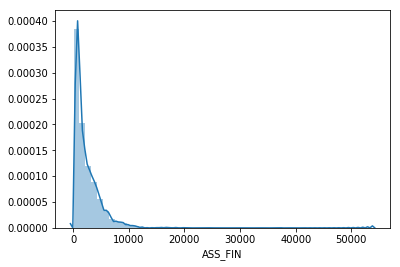

In [82]:
sns.distplot(ass['ASS_FIN'])

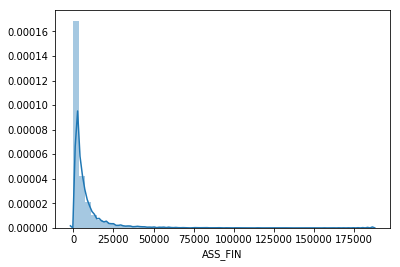

In [81]:
sns.distplot(data['ASS_FIN'])

In [63]:
totm['M_TOT_SAVING'].describe()

count    141750.000000
mean         58.095275
std          53.261449
min           0.278316
25%          19.347044
50%          41.050763
75%          81.420015
max         521.268059
Name: M_TOT_SAVING, dtype: float64

In [64]:
data['M_TOT_SAVING'].describe()

count    17076.000000
mean       103.914558
std        129.567122
min          1.000000
25%         30.000000
50%         70.000000
75%        135.000000
max       2500.000000
Name: M_TOT_SAVING, dtype: float64

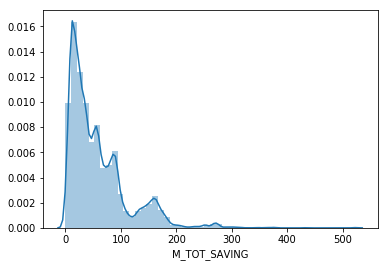

In [80]:
sns.distplot(totm['M_TOT_SAVING'])

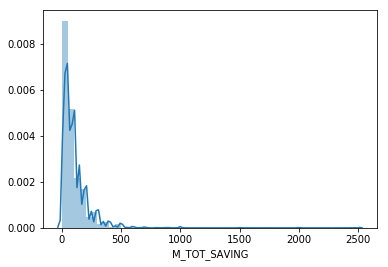

In [79]:
sns.distplot(data['M_TOT_SAVING'])

In [70]:
tots['TOT_SOBI'].describe()

count    141750.000000
mean        165.984863
std          98.034812
min           4.949743
25%          91.471802
50%         155.456085
75%         225.429699
max         624.955688
Name: TOT_SOBI, dtype: float64

In [71]:
data['TOT_SOBI'].describe()

count    17076.000000
mean       221.579175
std        193.530906
min          1.000000
25%        100.000000
50%        200.000000
75%        300.000000
max       6000.000000
Name: TOT_SOBI, dtype: float64

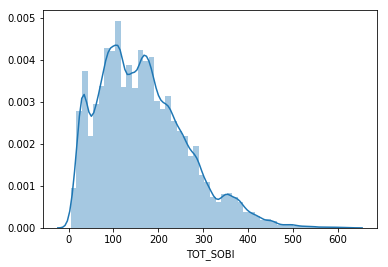

In [78]:
sns.distplot(tots['TOT_SOBI'])

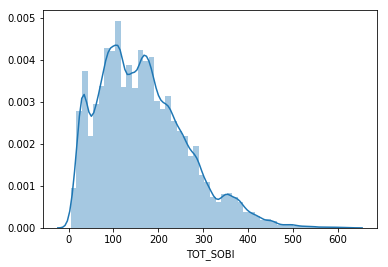

In [77]:
sns.distplot(tots['TOT_SOBI'])

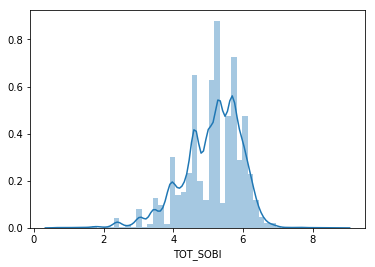

In [73]:
sns.distplot(np.log1p(data['TOT_SOBI']))

In [74]:
data_set1 = pd.concat([raw['SEX_GBN'], data_set['AGE_GBN'], raw['JOB_GBN'], data_set.iloc[:,1:6], ass['ASS_FIN'], totm['M_TOT_SAVING'], tots['TOT_SOBI']], axis = 1)

In [75]:
data_set1.head()

,SEX_GBN,AGE_GBN,JOB_GBN,ADD_GBN,INCOME_GBN,MARRY_Y,DOUBLE_IN,NUMCHILD,ASS_FIN,M_TOT_SAVING,TOT_SOBI
0,1,2,2,1,1,1.0,1.0,0.0,149.272428,18.691837,29.998798
1,1,2,2,1,1,2.0,1.0,0.0,393.793818,13.060307,26.676347
2,1,2,2,1,1,4.0,1.0,0.0,483.979332,5.877057,33.261362
3,1,2,2,1,1,1.0,2.0,0.0,149.272428,18.691837,29.998798
4,1,2,2,1,1,2.0,2.0,0.0,416.393802,13.540199,12.658689


In [76]:
data_set1.to_csv('SHINHANBANK_Mission_NO1.csv', mode = 'w', index = False)